In [2]:
# imports
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from math import factorial


In [3]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
# copied from: http://scipy-cookbook.readthedocs.io/items/SavitzkyGolay.html
# Need this for smoothing of the loss values
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid') 

In [37]:
def display_results(resnet):
    print('\033[1m' + 'The following data was optained with a resnet: '+resnet+'\033[0m')
    learning_rate = 0.00001
    mean = []
    accuracy = []
    for k in range(4):

        passed_img = np.fromfile('./data/'+resnet+'/lr_'+str(learning_rate)+'/passed_img_lr'+str(learning_rate)+'.dat', dtype=float)
        passed_lbl = np.fromfile('./data/'+resnet+'/lr_'+str(learning_rate)+'/passed_lbl_lr'+str(learning_rate)+'.dat', dtype=int)
        failed_img = np.fromfile('./data/'+resnet+'/lr_'+str(learning_rate)+'/failed_img_lr'+str(learning_rate)+'.dat', dtype=float)
        failed_lbl = np.fromfile('./data/'+resnet+'/lr_'+str(learning_rate)+'/failed_lbl_lr'+str(learning_rate)+'.dat', dtype=int)
        epoch_loss = np.fromfile('./data/'+resnet+'/lr_'+str(learning_rate)+'/epoch_loss_history_lr'+str(learning_rate)+'.dat', dtype=float)
        test_loss = np.fromfile('./data/'+resnet+'/lr_'+str(learning_rate)+'/test_loss_history_lr'+str(learning_rate)+'.dat', dtype=float)
        train_loss = np.fromfile('./data/'+resnet+'/lr_'+str(learning_rate)+'/train_loss_history_lr'+str(learning_rate)+'.dat', dtype=float)

        passed_lbl = np.reshape(passed_lbl, (len(passed_lbl)//10, 10))
        failed_lbl = np.reshape(failed_lbl, (len(failed_lbl)//10, 10))
        if resnet == 'resnet_18': # The first net saved all passed and failed images
            passed_img = np.reshape(passed_img, (len(passed_lbl), 3, 32, 32))
            failed_img = np.reshape(failed_img, (len(failed_lbl), 3, 32, 32))
        else: # The following nets only 4 passed and failed images were saved
            passed_img = np.reshape(passed_img, (4, 3, 32, 32))
            failed_img = np.reshape(failed_img, (4, 3, 32, 32))

        accuracy.append(100*len(passed_lbl)/(len(passed_lbl)+(len(failed_lbl))))
            
        print('The following data was optained with a learning rate of '+str(learning_rate))
        print('The accuracy of the Network was: '+str(accuracy[k])+'%')
        print("some passed images with their predicted labels:")
        fig1 = plt.figure()
        ax1 = [fig1.add_subplot(131), fig1.add_subplot(132), fig1.add_subplot(133)]

        for i in range(3):
            img = passed_img[i] / 2 + 0.5
            ax1[i].set_title(classes[np.argmax(passed_lbl[i])])
            ax1[i].imshow(np.transpose(img, (1, 2, 0)))
        plt.show()
        print("some failed images with their predicted labels:")
        fig2 = plt.figure()
        ax2 = [fig2.add_subplot(131), fig2.add_subplot(132), fig2.add_subplot(133)]

        for i in range(3):
            img = failed_img[i] / 2 + 0.5
            ax2[i].set_title(classes[np.argmax(failed_lbl[i])])
            ax2[i].imshow(np.transpose(img, (1, 2, 0)))
        plt.show()    


        zeros = np.argwhere(epoch_loss==0)

        for i in range(len(zeros)-1):
            y = epoch_loss[zeros[i][0]:zeros[i+1][0]]
            x = np.linspace(i, i+1, len(y))
            plt.plot(x, y)

        print('Epoch los history')
        plt.ylabel('epoch loss history')
        plt.xlabel('epoch index')
        plt.show()

        print('Train loss history')
        print('In average, the loss becomes smaller with other training cycle')
        plt.plot(savitzky_golay(train_loss, 101, 1)) # smooth the loss values in order to get a more expressive plot
        plt.ylabel('Train loss history')
        plt.xlabel('index')
        plt.show()

        mean.append(np.mean(test_loss))
        print('Smoothed test loss history')
        print('Now, there is obviously no more improovement or degradation')
        print('The mean loss of the Test is: '+str(mean[k]))
        plt.plot(savitzky_golay(test_loss, 101, 1))
        plt.ylabel('Test loss history')
        plt.xlabel('index')
        plt.show()

        learning_rate = learning_rate * 10
        
    print('The test with the lowest mean had a learning rate of: '+str(0.00001*(10**np.argmin(np.array(mean))))+' winth an accuracy of: '+str(np.max(np.array(accuracy)))+'%')
    
    assert np.argmin(np.array(mean)) == np.argmax(np.array(accuracy))
    return np.min(np.array(mean)), np.max(np.array(accuracy))

The following data was optained with a resnet: resnet_18
The following data was optained with a learning rate of 1e-05
The accuracy of the Network was: 72.85%
some passed images with their predicted labels:


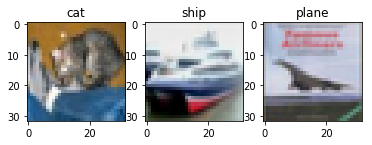

some failed images with their predicted labels:


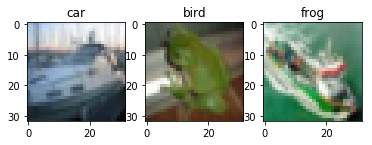

Epoch los history


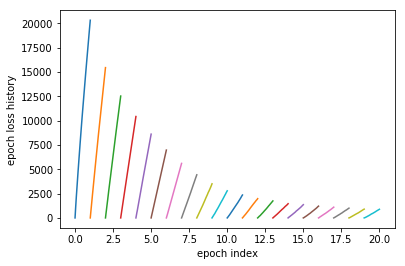

Train loss history
In average, the loss becomes smaller with other training cycle


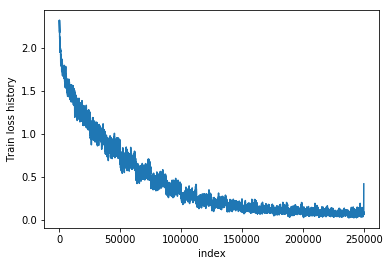

Smoothed test loss history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 1.0970909714102746


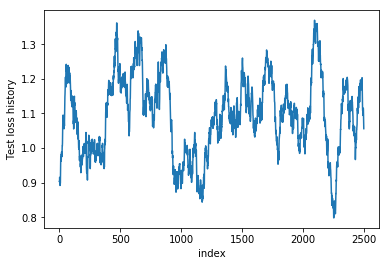

The following data was optained with a learning rate of 0.0001
The accuracy of the Network was: 83.5%
some passed images with their predicted labels:


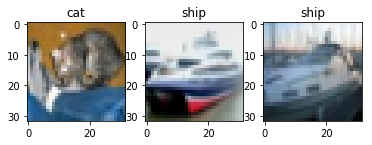

some failed images with their predicted labels:


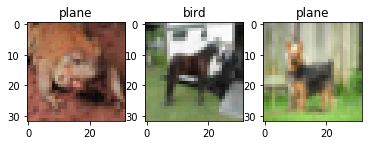

Epoch los history


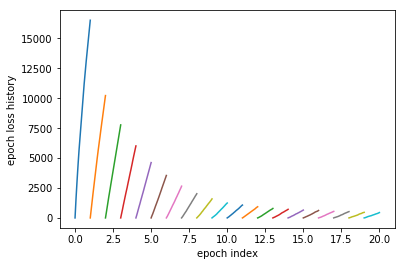

Train loss history
In average, the loss becomes smaller with other training cycle


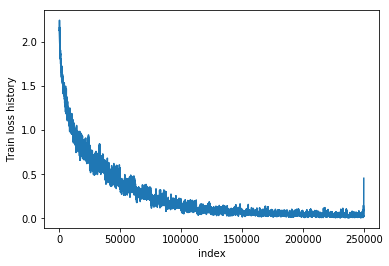

Smoothed test loss history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 0.7283817892067135


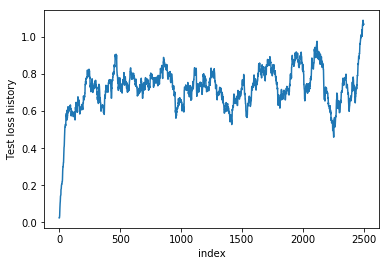

The following data was optained with a learning rate of 0.001
The accuracy of the Network was: 82.55%
some passed images with their predicted labels:


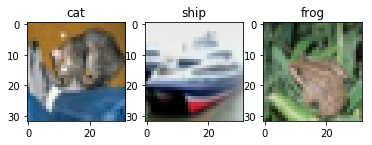

some failed images with their predicted labels:


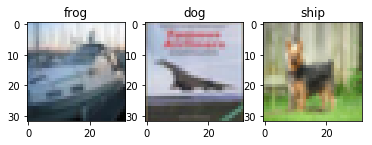

Epoch los history


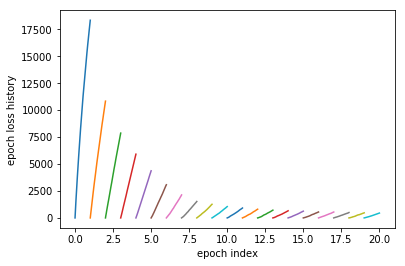

Train loss history
In average, the loss becomes smaller with other training cycle


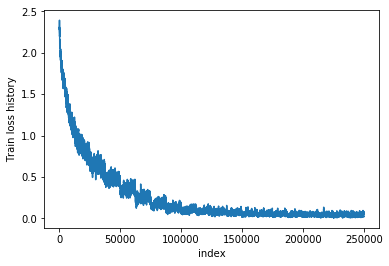

Smoothed test loss history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 0.8896898394628427


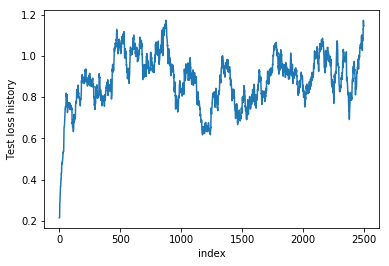

The following data was optained with a learning rate of 0.01
The accuracy of the Network was: 78.46%
some passed images with their predicted labels:


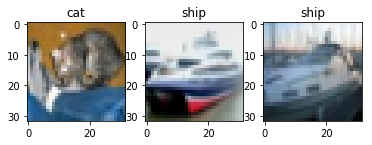

some failed images with their predicted labels:


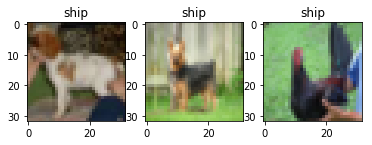

Epoch los history


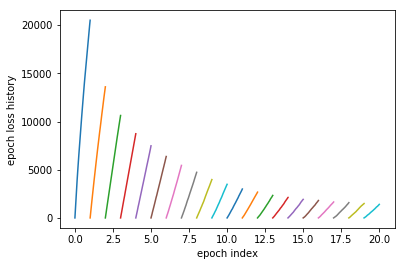

Train loss history
In average, the loss becomes smaller with other training cycle


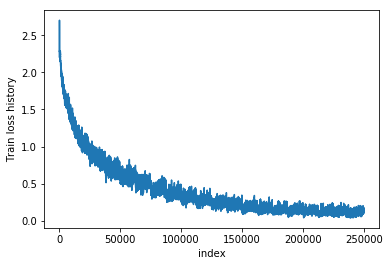

Smoothed test loss history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 1.0862021592783975


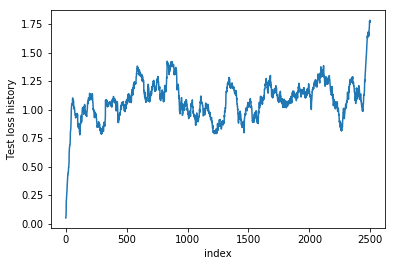

The test with the lowest mean had a learning rate of: 0.0001 winth an accuracy of: 83.5%


In [38]:
best_mean, best_acc = display_results('resnet_18')

The following data was optained with a resnet: resnet_34
The following data was optained with a learning rate of 1e-05
The accuracy of the Network was: 73.6%
some passed images with their predicted labels:


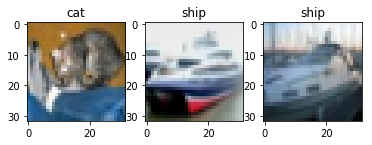

some failed images with their predicted labels:


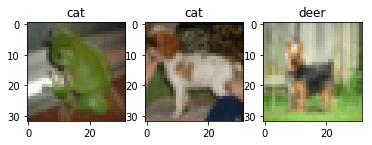

Epoch los history


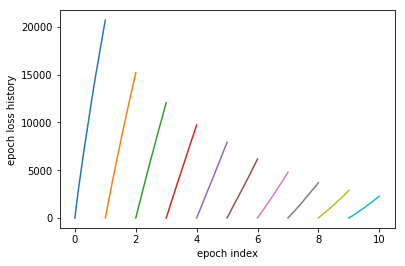

Train loss history
In average, the loss becomes smaller with other training cycle


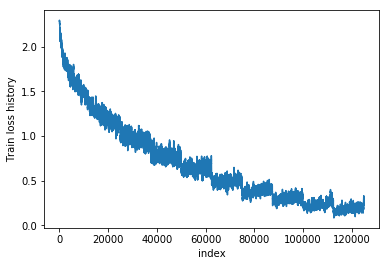

Smoothed test loss history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 0.9384784503102302


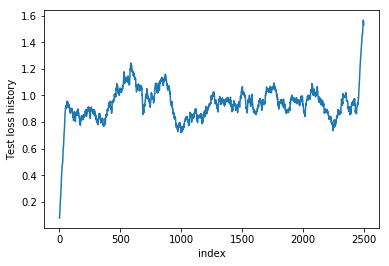

The following data was optained with a learning rate of 0.0001
The accuracy of the Network was: 83.29%
some passed images with their predicted labels:


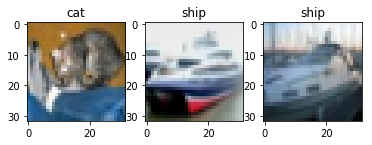

some failed images with their predicted labels:


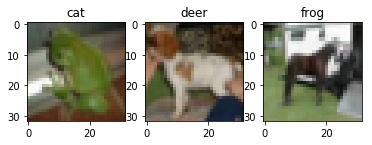

Epoch los history


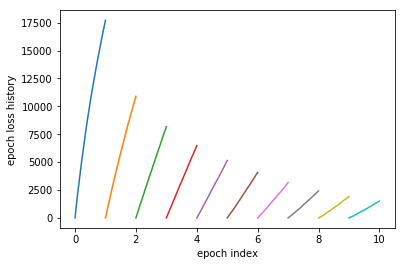

Train loss history
In average, the loss becomes smaller with other training cycle


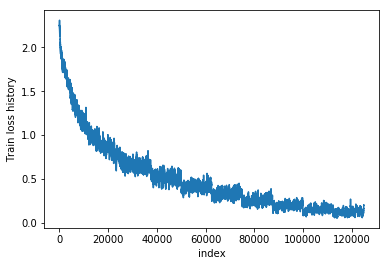

Smoothed test loss history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 0.611871441732347


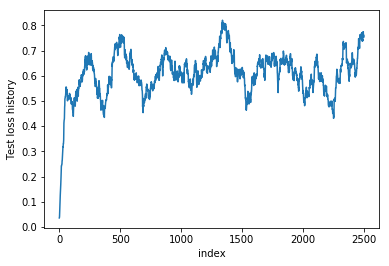

The following data was optained with a learning rate of 0.001
The accuracy of the Network was: 82.49%
some passed images with their predicted labels:


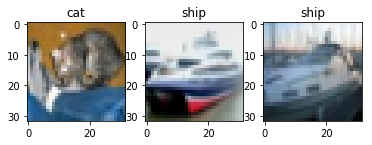

some failed images with their predicted labels:


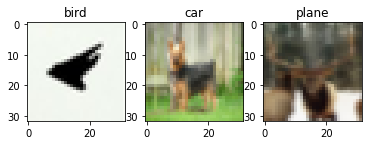

Epoch los history


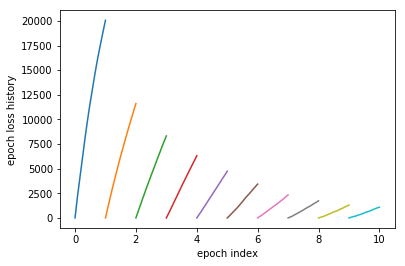

Train loss history
In average, the loss becomes smaller with other training cycle


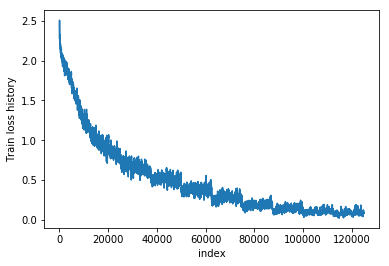

Smoothed test loss history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 0.7270124272540212


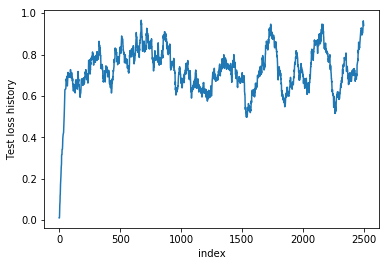

The following data was optained with a learning rate of 0.01
The accuracy of the Network was: 78.89%
some passed images with their predicted labels:


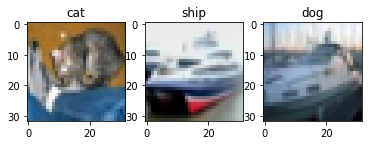

some failed images with their predicted labels:


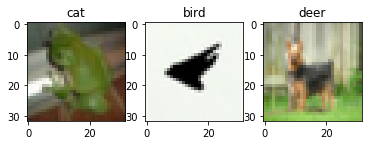

Epoch los history


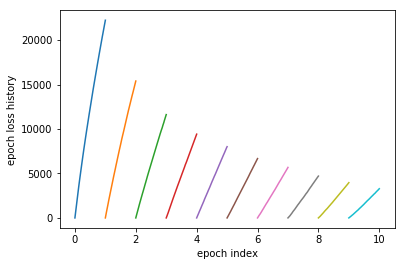

Train loss history
In average, the loss becomes smaller with other training cycle


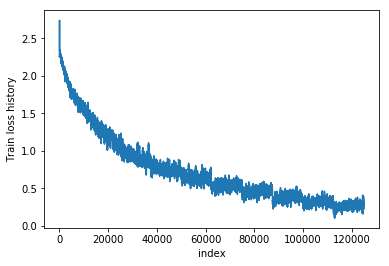

Smoothed test loss history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 0.757210041366145


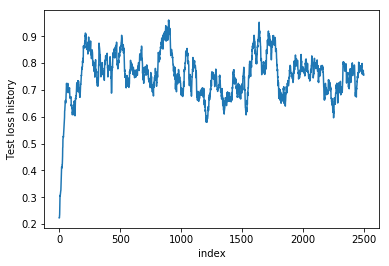

The test with the lowest mean had a learning rate of: 0.0001 winth an accuracy of: 83.29%


(0.611871441732347, 83.29)

In [39]:
display_results('resnet_34')

The following data was optained with a resnet: resnet_50
The following data was optained with a learning rate of 1e-05
The accuracy of the Network was: 71.32%
some passed images with their predicted labels:


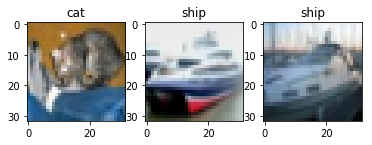

some failed images with their predicted labels:


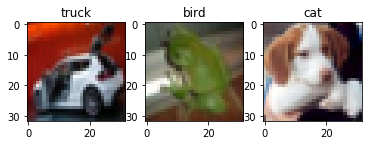

Epoch los history


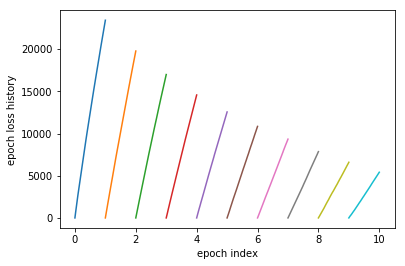

Train loss history
In average, the loss becomes smaller with other training cycle


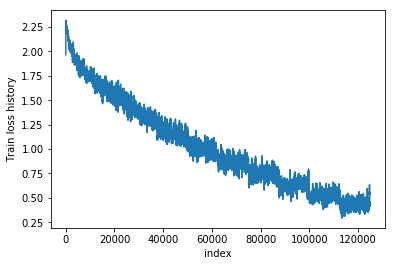

Smoothed test loss history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 0.8936655307769775


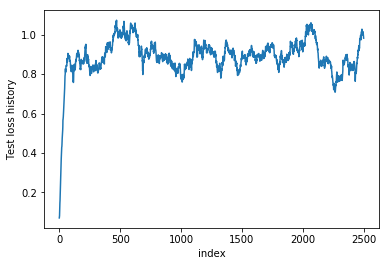

The following data was optained with a learning rate of 0.0001
The accuracy of the Network was: 82.73%
some passed images with their predicted labels:


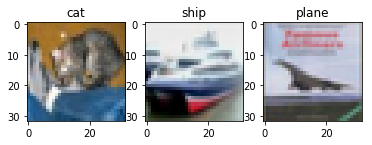

some failed images with their predicted labels:


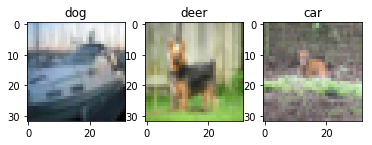

Epoch los history


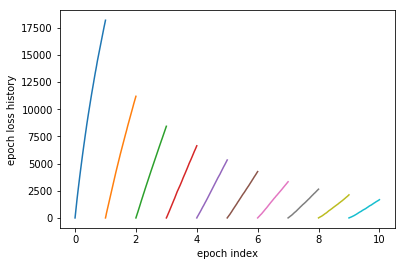

Train loss history
In average, the loss becomes smaller with other training cycle


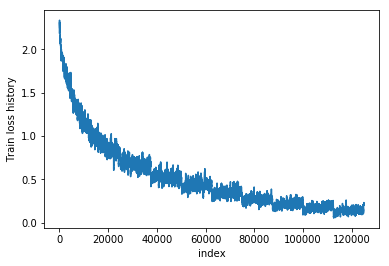

Smoothed test loss history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 0.6066431093260646


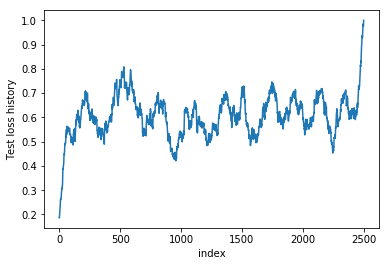

The following data was optained with a learning rate of 0.001
The accuracy of the Network was: 80.5%
some passed images with their predicted labels:


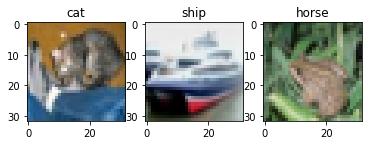

some failed images with their predicted labels:


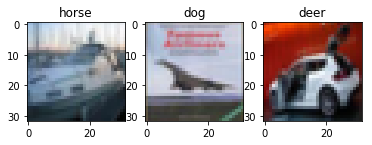

Epoch los history


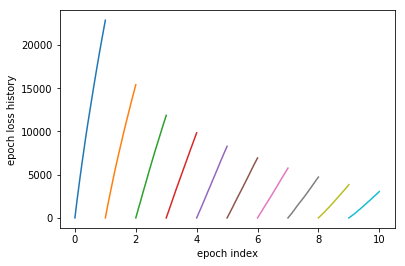

Train loss history
In average, the loss becomes smaller with other training cycle


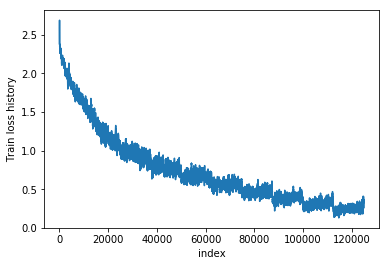

Smoothed test loss history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 0.6305058763043023


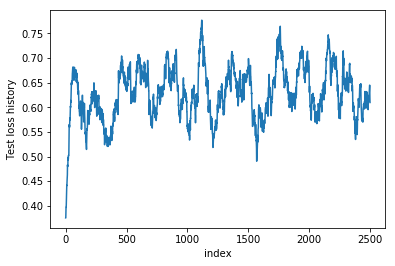

The following data was optained with a learning rate of 0.01
The accuracy of the Network was: 74.23%
some passed images with their predicted labels:


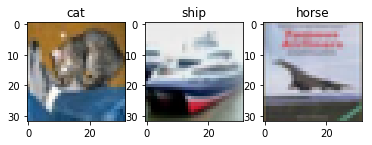

some failed images with their predicted labels:


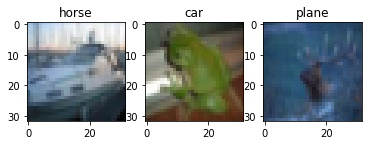

Epoch los history


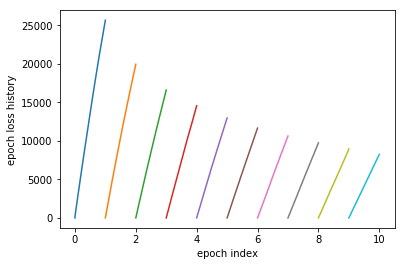

Train loss history
In average, the loss becomes smaller with other training cycle


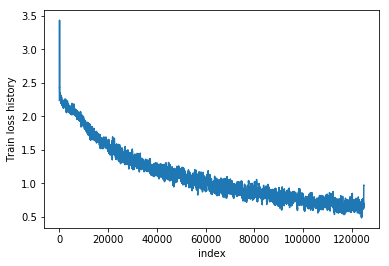

Smoothed test loss history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 0.760886550141871


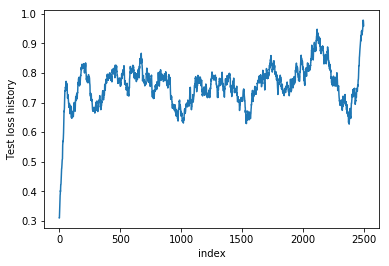

The test with the lowest mean had a learning rate of: 0.0001 winth an accuracy of: 82.73%


(0.6066431093260646, 82.73)

In [40]:
display_results('resnet_50')

The following data was optained with a resnet: resnet_101
The following data was optained with a learning rate of 1e-05
The accuracy of the Network was: 72.41%
some passed images with their predicted labels:


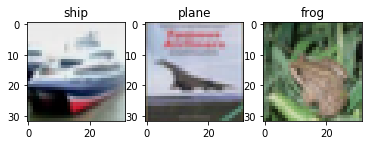

some failed images with their predicted labels:


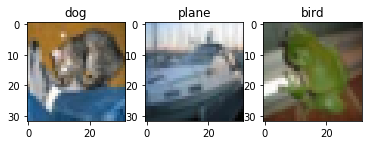

Epoch los history


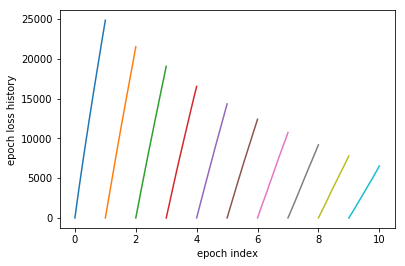

Train loss history
In average, the loss becomes smaller with other training cycle


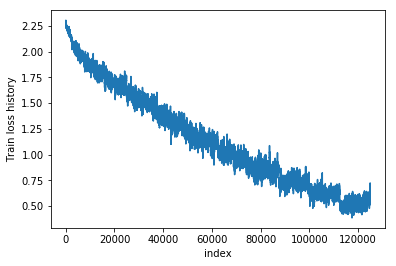

Smoothed test loss history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 0.8327353526711464


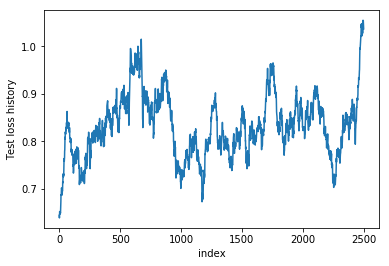

The following data was optained with a learning rate of 0.0001
The accuracy of the Network was: 83.54%
some passed images with their predicted labels:


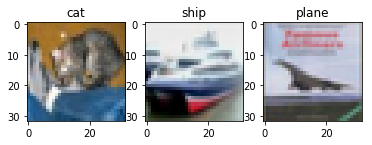

some failed images with their predicted labels:


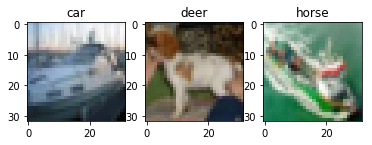

Epoch los history


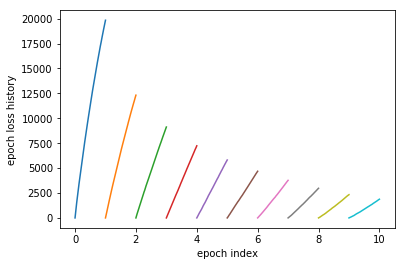

Train loss history
In average, the loss becomes smaller with other training cycle


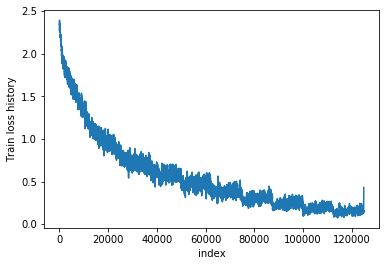

Smoothed test loss history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 0.5704052112929523


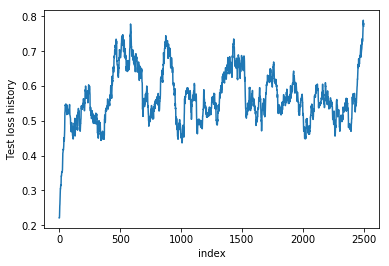

The following data was optained with a learning rate of 0.001
The accuracy of the Network was: 80.25%
some passed images with their predicted labels:


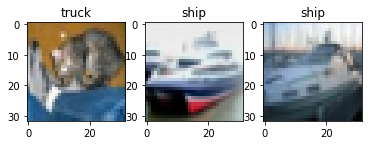

some failed images with their predicted labels:


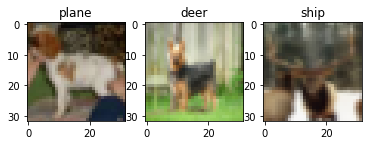

Epoch los history


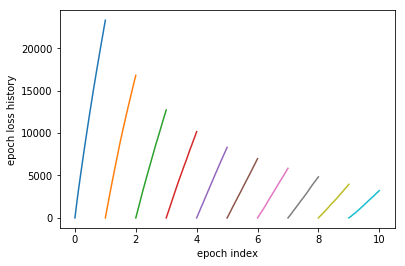

Train loss history
In average, the loss becomes smaller with other training cycle


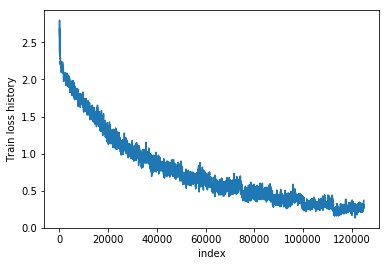

Smoothed test loss history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 0.6409052050966769


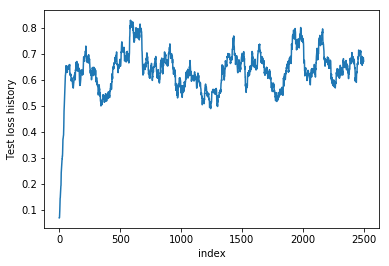

The following data was optained with a learning rate of 0.01
The accuracy of the Network was: 73.76%
some passed images with their predicted labels:


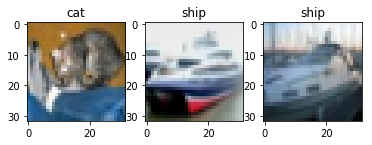

some failed images with their predicted labels:


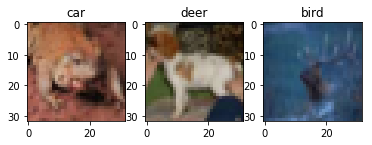

Epoch los history


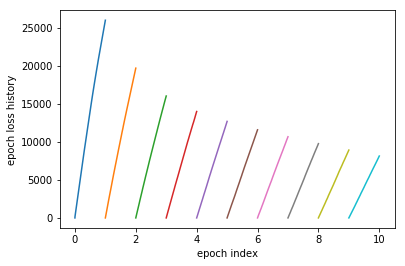

Train loss history
In average, the loss becomes smaller with other training cycle


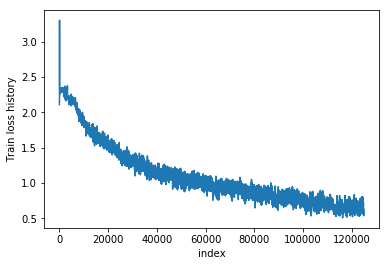

Smoothed test loss history
Now, there is obviously no more improovement or degradation
The mean loss of the Test is: 0.778947927762568


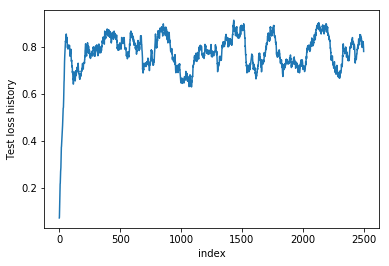

The test with the lowest mean had a learning rate of: 0.0001 winth an accuracy of: 83.54%


(0.5704052112929523, 83.54)

In [41]:
display_results('resnet_101')

In [42]:
display_results('resnet_152') # The training and testing of this network was not finished before the due date

The following data was optained with a resnet: resnet_152


FileNotFoundError: [Errno 2] No such file or directory: './data/resnet_152/lr_1e-05/passed_img_lr1e-05.dat'